# Example for using the GEDA sampler


In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
import torch
from torch import nn

import swyft
import pylab as plt
import scipy.stats.distributions as dist

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

In [11]:
class PowerSampler:
    def __init__(self, N, boxlength = 1.0):
        self.N = N
        d = boxlength/N
        freq = torch.fft.fftfreq(N, d=d)
        kx, ky = torch.meshgrid(freq, freq)
        k = (kx**2+ky**2)**0.5
        self.k = k + k[0,1]  # Offset to avoid singularities

    def sample(self, pk):
        N = self.N
        A = torch.randn(N,N)+1j*torch.randn(N,N)  # Random complex amplitudes
        phi_k = A*pk(self.k)
        phi_x = torch.fft.ifft2(phi_k)
        return phi_x.real

In [12]:
N = 1024
p = PowerSampler(N)
k = p.k
D2 = (1/k**2.5).view(N*N).double().cuda()
D2 = 0.0001/D2

In [13]:
#L = torch.zeros(N*N, N*N).cuda().double()
#dd = torch.ones(N*N)
#dd[:N*N//2] = 0
#L = torch.diag(dd).cuda().double()
#for i in range(N):
#    j, k = i//8, i%8
#    print(j, k)
#    L[i,j:j+1,k:k+1] = 1.
#L = L.view(-1, N*N)
#G1 = lambda x: torch.matmul(L, x)
G1 = lambda x: x
D1 = torch.ones(N*N).cuda().double()*1
D1[:N*N//2] = 0.001
#G1T = lambda x: torch.matmul(L.T, x)
G1T = lambda x: x
U2 = lambda x: torch.fft.fft2(x.view(N, N), norm = 'ortho').view(N*N)
U2T = lambda x: torch.fft.ifft2(x.view(N, N), norm = 'ortho').view(N*N)
geda = swyft.utils.GEDASampler(1e0, G1, D1, G1T, U2, D2, U2T)

In [14]:
import tqdm.auto as tqdm

In [15]:
x = geda.sample(16, steps = 100)

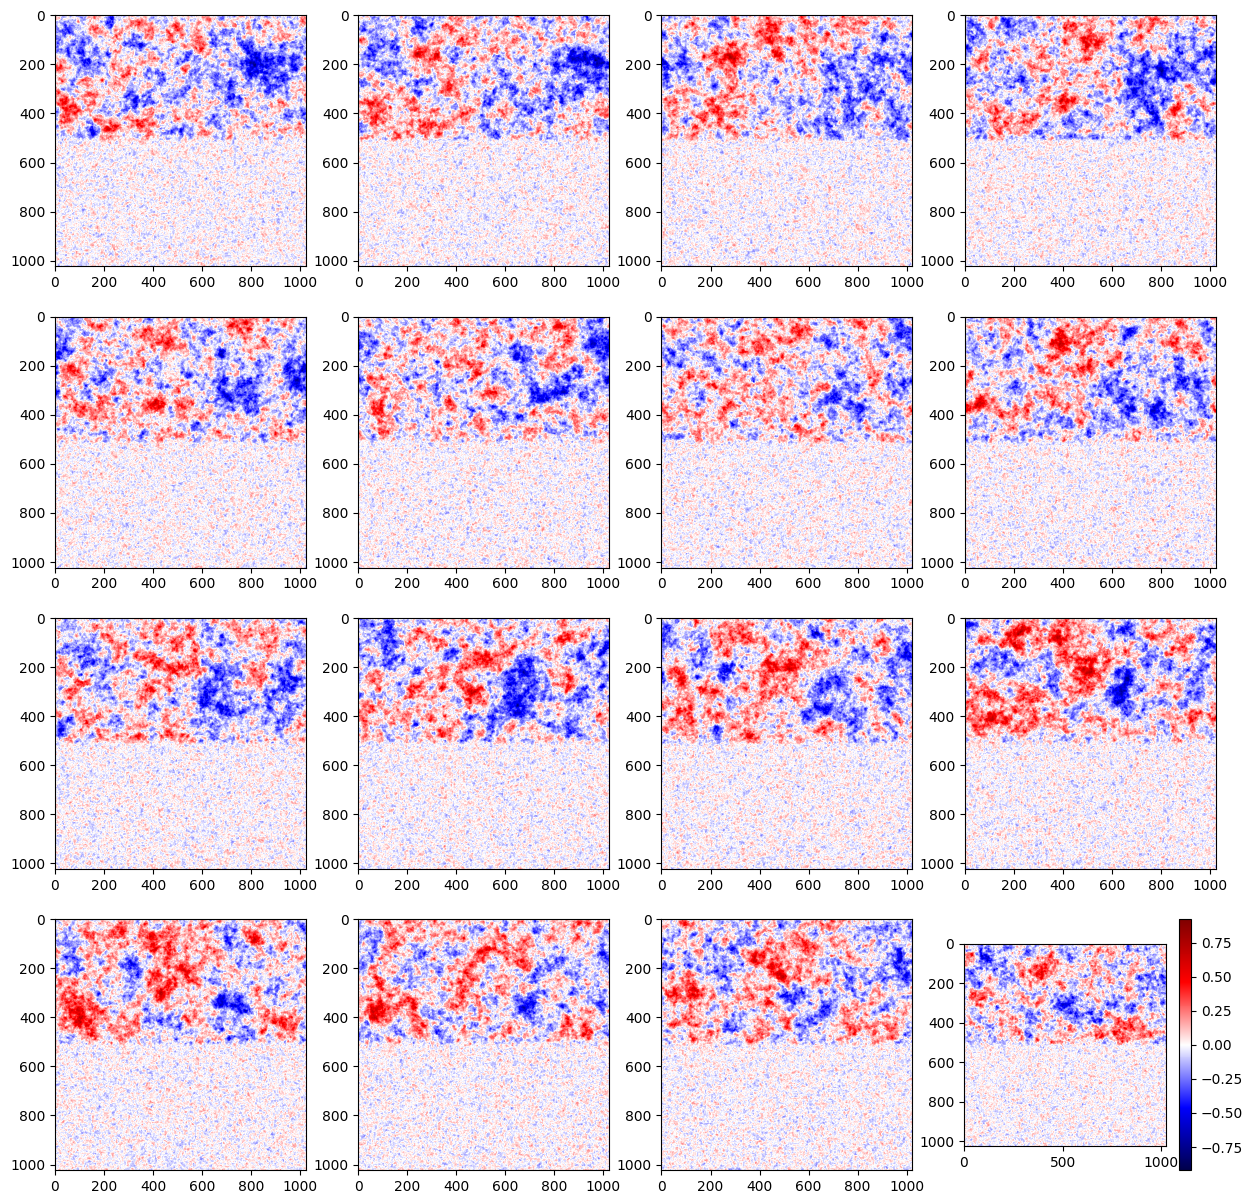

In [16]:
v = torch.abs(x[0]).max()
plt.figure(figsize = (15, 15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x[i].view(N, N).cpu(), vmin = -v, vmax = v, cmap = 'seismic')
plt.colorbar()